<a href="https://colab.research.google.com/github/fjadidi2001/Image_Inpaint/blob/main/FastInpaintingNet-Jan25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install datasets


In [2]:
from datasets import load_dataset
import pandas as pd

# Load the CelebA-HQ dataset
ds = load_dataset("saitsharipov/CelebA-HQ")

# Check if dataset loaded correctly
if ds is None:
    raise ValueError("Dataset not loaded correctly")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Dataset structure:
DatasetDict({
    train: Dataset({
        features: ['image'],
        num_rows: 202599
    })
})

First few items in the training set:
Item 0:
  image: Image with shape (178, 218)


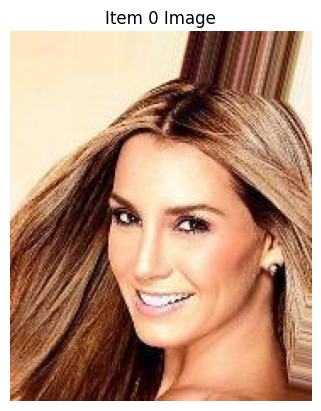


Item 1:
  image: Image with shape (178, 218)


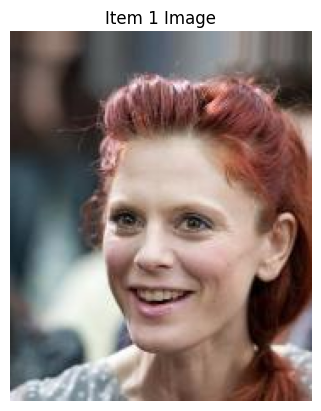


Item 2:
  image: Image with shape (178, 218)


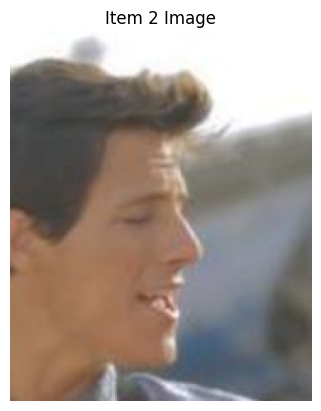


Item 3:
  image: Image with shape (178, 218)


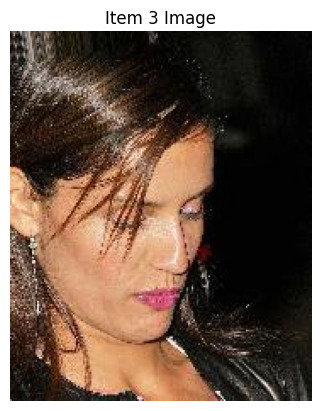


Item 4:
  image: Image with shape (178, 218)


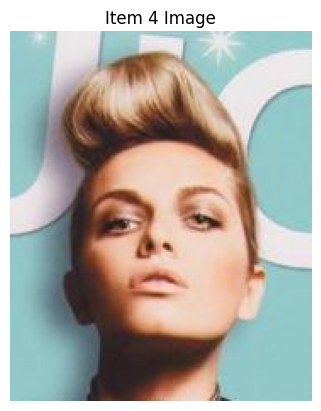



Column names:
['image']

DataFrame head:
                                               image
0  <PIL.JpegImagePlugin.JpegImageFile image mode=...
1  <PIL.JpegImagePlugin.JpegImageFile image mode=...
2  <PIL.JpegImagePlugin.JpegImageFile image mode=...
3  <PIL.JpegImagePlugin.JpegImageFile image mode=...
4  <PIL.JpegImagePlugin.JpegImageFile image mode=...

Column data types:
image    object
dtype: object


In [4]:
from datasets import load_dataset
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

# Load the CelebA-HQ dataset
try:
    ds = load_dataset("saitsharipov/CelebA-HQ")
except Exception as e:
    print(f"Error loading dataset: {e}")
    exit()

# Print basic information about the dataset
print("Dataset structure:")
print(ds)

# Inspect the first few items in the training set
print("\nFirst few items in the training set:")
for i, item in enumerate(ds['train'].take(5)):
    print(f"Item {i}:")
    for key, value in item.items():
        if key == 'image':
            print(f"  {key}: Image with shape {value.size}")
            # Display the image
            plt.imshow(value)
            plt.title(f"Item {i} Image")
            plt.axis('off')
            plt.show()
        else:
            print(f"  {key}: {value}")
    print()

# Get all column names (attributes)
column_names = list(ds['train'].features.keys())
print("\nColumn names:")
print(column_names)

# Convert a small subset of the dataset to a pandas DataFrame for easier inspection
df = pd.DataFrame(ds['train'].select(range(100)))
print("\nDataFrame head:")
print(df.head())

# Print data types of columns
print("\nColumn data types:")
print(df.dtypes)